In [25]:
# done at hackaton event
# https://www.meetup.com/Machine-Learning-Tokyo/events/249224794/

In [1]:
import numpy as np
import cv2 
import time
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# required data
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
# http://vis-www.cs.umass.edu/lfw/#download

In [2]:
from keras.models import Model
from keras.layers import Input, Dense
import tensorflow as tf

Using TensorFlow backend.


In [3]:
class BottlenecksTransform:
    # TODO rewrite.. enum vs policy.. policy wins due to open close principle
    # TODO add the other models https://keras.io/applications/

    VGG16           = 1
    VGG19           = 2
    RESNET50        = 3
    INCEPTIONV3     = 4
    XCEPTION        = 5
    INCEPTIONRES2V3 = 6
    MOBILENET       = 7
    
    def __init__(self, model_type=INCEPTIONV3,  weights="imagenet"):       
        if model_type == BottlenecksTransform.VGG16:
            import keras.applications.vgg16

            base_model   = keras.applications.vgg16.VGG16(weights=weights)
            output_layer = base_model.get_layer('fc1')
            
            self.preprocessor = keras.applications.vgg16.preprocess_input
	    self.model = Model(inputs=base_model.input, outputs=output_layer.output)
	    self.input_size  = (224, 224)
	    self.output_size = output_layer.output_shape
        elif model_type == BottlenecksTransform.VGG19:
            import keras.applications.vgg19

            base_model = keras.applications.vgg19.VGG19(weights=weights)
            output_layer = base_model.get_layer('fc1')

            self.preprocessor = keras.applications.vgg19.preprocess_input
	    self.model = Model(inputs=base_model.input, outputs=output_layer.output)
            self.input_size = (224, 224)
	    self.output_size = output_layer.output_shape
        elif model_type == BottlenecksTransform.RESNET50:
            import keras.applications.resnet50

            base_model = keras.applications.resnet50.ResNet50(weights=weights)
            output_layer = base_model.get_layer('flatten')

            self.preprocessor = keras.applications.resnet50.preprocess_input
	    self.model = Model(inputs=base_model.input, outputs=output_layer.output)
            self.input_size = (224, 224)
	    self.output_size = output_layer.output_shape
        elif model_type == BottlenecksTransform.INCEPTIONV3:
            import keras.applications.inception_v3

            base_model = keras.applications.inception_v3.InceptionV3(weights=weights)
            output_layer = base_model.get_layer('avg_pool')

            self.preprocessor = keras.applications.inception_v3.preprocess_input
	    self.model = Model(inputs=base_model.input, outputs=output_layer.output)
            self.input_size = (299, 299)
            self.output_size = output_layer.output_shape
        elif model_type == BottlenecksTransform.XCEPTION:
            import keras.applications.xceptione

            base_model = keras.applications.xception.Xception(weights=weights)
            output_layer = base_model.get_layer('avg_pool')

            self.preprocessor = keras.applications.xception.preprocess_input
	    self.model = Model(inputs=base_model.input, outputs=output_layer.output)
            self.input_size = (299, 299)
	    self.output_size = output_layer.output_shape

        elif model_type == BottlenecksTransform.MOBILENET:
            import keras.applications.mobilenet

            base_model = keras.applications.mobilenet.MobileNet(weights=weights)
            output_layer = base_model.get_layer('act_softmax')

            self.preprocessor = keras.applications.mobilenet.preprocess_input
	    self.model = Model(inputs=base_model.input, outputs=output_layer.output)
            self.input_size = (224, 224)
	    self.output_size = output_layer.output_shape
        else:
            raise ValueError("no idea what " + model_name + " is..")

    # allocate for multiple ouputs from __call__
    def allocate(self,samples,patch_size,channels):
        shape = (samples,) + self.output_size[1:]
        return np.zeros(shape)

    # designed for single data point
    def __call__(self, data):
        # data shape: height, width, channel

        # ouch my gpu doesnt have the memory for these large  models..
        # make certain we are using the cpu..
        with tf.device('/cpu:0'):
            # resize patch into networks input size
            scaled = np.zeros(self.input_size + (data.shape[2],))
            for i in range(data.shape[2]):
                scaled[:,:,i] = cv2.resize(data[:,:,i],self.input_size, interpolation = cv2.INTER_CUBIC)
                
            # the preprocessing is model specifc.. (hope this doesnt compound oddly)
            pre_processed = self.preprocessor(scaled)

            # generate the bottlenext features
            pre_processed = pre_processed.reshape((1,) + pre_processed.shape)
            features = self.model.predict(pre_processed)

            features = features.reshape(features.shape[1:])
                   
        return features

In [4]:
class NecksModel:
    def __init__(self, 
                 embedding_size=2048,
                 layer_sizes=[80,8]):
        
        inputs = Input(shape=(embedding_size,))
        x = inputs
        for s in layer_sizes:
            x = Dense(s, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.summary()
        
        self.model = model
                
    def train(self, data_i, data_o):
        # Fit the model
        self.model.fit(data_i, data_o, epochs=150, batch_size=10)
        
    def predict(self, data_i):
        return self.model.predict(data_i)

In [5]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('data/haarcascade_eye.xml')

def extract_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    roi_stack = []
    for (x,y,w,h) in faces:
        #cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_color = img[y:y+h, x:x+w]
        roi_gray  = gray[y:y+h, x:x+w]

        roi_stack.append((np.copy(roi_color),x,y,w,h))

        # note this marks the eyes.. where its anchoring
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            
    return roi_stack

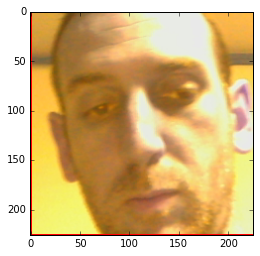

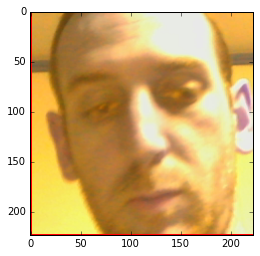

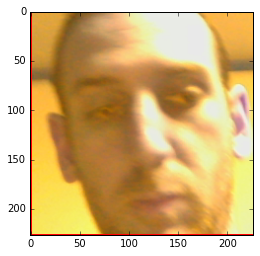

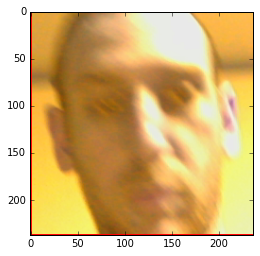

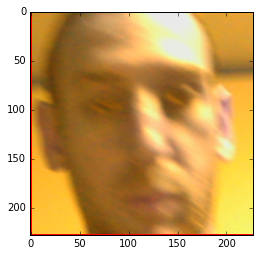

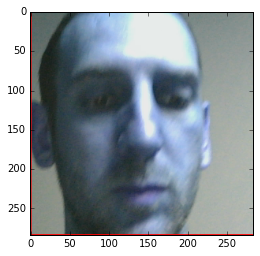

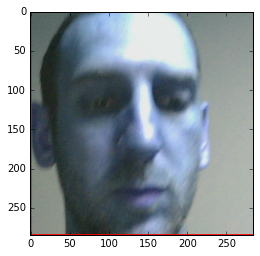

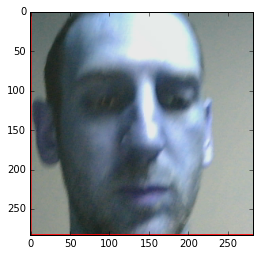

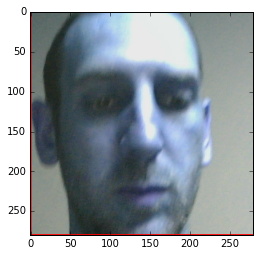

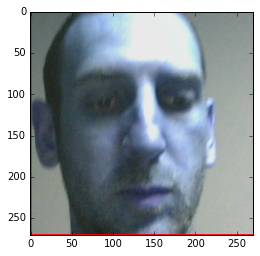

In [14]:
# aquire the target to recognise

target_data = []
cam = cv2.VideoCapture(0)
while len(target_data) < 10:
    ret, img = cam.read()
    roi_stack = extract_faces(img)

    if len(roi_stack) > 0: 
        img = roi_stack[0][0]
        target_data.append(img)
        plt.imshow(img)
        plt.show()
        time.sleep(1)
    
cam.release()

# TODO.. why is it blue or yellow

In [7]:
# load in negative data
limit = 200
negative_data = []
image_paths = glob.glob('lfw_data/*/*.jpg')


for filename in image_paths:
    img = cv2.imread(filename, )
    roi_stack = extract_faces(img)
    
    if len(roi_stack) > 0: 
        img = roi_stack[0][0]
        negative_data.append(img)
        
    if len(negative_data) > limit: 
        break

In [8]:
necks = BottlenecksTransform()

In [9]:
labels = np.concatenate([np.zeros((len(negative_data))), np.ones((len(target_data)))])
labels.shape

(211,)

In [10]:
# convert images to embedding and merge negative with postive data 
emb_stack = []    
for r in negative_data:
    emb_stack.append(necks(r))

for r in target_data:
    emb_stack.append(necks(r))
                 
features = np.array(emb_stack)
features.shape

(211, 2048)

In [11]:
# now train model to select target from negative faces
model = NecksModel(embedding_size=necks.output_size[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                163920    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 648       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 164,577
Trainable params: 164,577
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.train(features,labels)

Epoch 1/150
211/211 [==============================] - 0s - loss: 2.7556e-06 - acc: 1.0000     
Epoch 2/150
211/211 [==============================] - 0s - loss: 2.7063e-06 - acc: 1.0000     
Epoch 3/150
211/211 [==============================] - 0s - loss: 2.6687e-06 - acc: 1.0000     
Epoch 4/150
211/211 [==============================] - 0s - loss: 2.6267e-06 - acc: 1.0000     

In [23]:
# ok go live mode -- press "esc" key to end
cv2.namedWindow("live", cv2.CV_WINDOW_AUTOSIZE) # naming helps window close.. go figure..

cam = cv2.VideoCapture(0)
while True:    
    ret, img = cam.read()

    roi_stack = extract_faces(img)

    for (roi_color,x,y,w,h) in roi_stack:        
        embed = necks(roi_color).reshape((1,necks.output_size[1]))
        res = model.predict(embed)
        
        if res[0] > 0.5:
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)        
        else:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)        

    cv2.imshow('live',img)
    
    # escape key to exit
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cam.release()

In [24]:
# bug with closing the window.. slam it until it works
for i in range(1,10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)